# X dosage compensation

In [1]:
source(here::here("scripts/init.R"))

We start by looking at the CNA data

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“Removed 12192 rows containing non-finite values (stat_density).”
Warning message:
“Removed 12192 rows containing non-finite values (stat_density).”


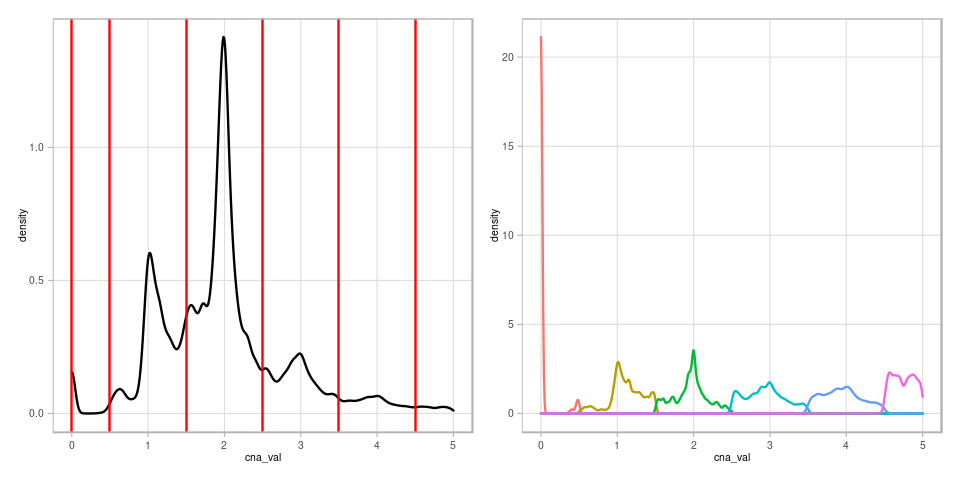

In [2]:
options(repr.plot.width = 8, repr.plot.height = 4)
p1 <- cna %>% ggplot(aes(x=cna_val)) + geom_density() + xlim(0,5) + geom_vline(xintercept=c(0,0.5, 1.5, 2.5, 3.5, 4.5), color="red") 
p2 <- cna %>% ggplot(aes(x=cna_val, color=factor(cna_round))) + geom_density() + xlim(0,5)  + guides(color=FALSE)
p1 + p2

## X analysis

We then go to extract loci that are associated with xist expression

In [3]:
xist_loci <- get_xist_loci()

xist_loci_meth <- get_xist_loci_meth()
xist_meth <- xist_loci_meth %>%
    group_by(samp) %>%
    summarise(meth = mean(meth, na.rm = TRUE))

xist_expr <- get_gene_expression_mat() %>%
    filter(name == "XIST") %>%
    gather("samp", "expr", -(chrom:name3.chr))

xist_loci_expr <- get_xist_loci_expr()
df <- xist_meth %>%
    left_join(xist_expr %>% select(samp, expr)) %>%
    left_join(samp_data %>% select(samp, ER = ER1)) %>%
    filter(!is.na(ER))

head(xist_loci)
count(xist_loci, chrom)

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end")

Joining, by = "samp"

Joining, by = "samp"



chrom,start,end
<chr>,<dbl>,<dbl>
chrX,9983293,9983844
chrX,11776199,11776750
chrX,14891025,14891576
chrX,16964312,16964863
chrX,17393041,17393592
chrX,18443223,18443774


chrom,n
<chr>,<int>
chrX,615


We show that Xist expression is correlated with XIST loci methylation

In [4]:
head(df)

samp,meth,expr,ER
<chr>,<dbl>,<dbl>,<chr>
MB_0006,0.3131481,8.088802,ER+
MB_0028,0.1560928,6.482577,ER+
MB_0030,0.3030659,NA,ER+
MB_0035,0.1877706,6.406843,ER-
MB_0040,0.2148237,NA,ER+
MB_0046,0.1631259,6.652839,ER+


#### Extended Data Figure 9B

ER,cor
<chr>,<dbl>
ER-,0.6021123
ER+,0.5171663
normal,0.4914330


Warning message:
“Removed 263 rows containing missing values (geom_point).”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


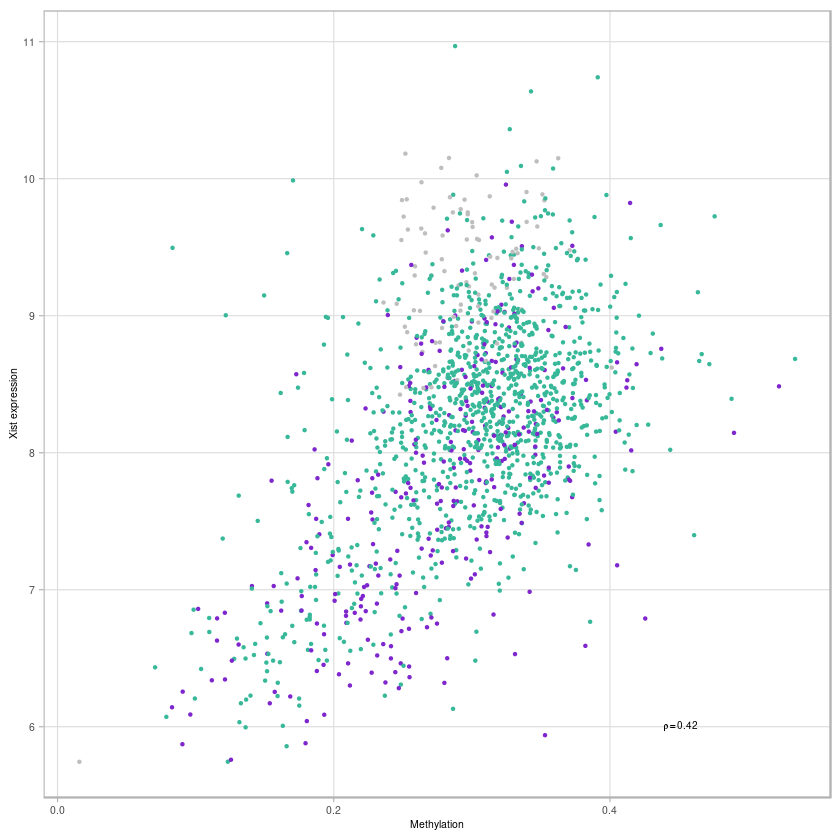

In [5]:
options(repr.plot.width = 7, repr.plot.height = 7)
df %>% group_by(ER) %>% summarise(cor = cor(meth, expr, use="pairwise.complete.obs"))
p_xist_meth_cor <- df %>%
    arrange(sample(samp)) %>% 
    ggplot(aes(x = meth, y = expr, color = ER)) +
    geom_point(size=0.2) + 
    scale_color_manual(values = annot_colors$ER1, guide = FALSE) +
    theme(aspect.ratio = 1) +
    xlab("Methylation") +
    ylab("Xist expression") +
    annotate("text", x = 0.45, y = 6, label = sprintf("~ rho == %0.2f", cor(df$meth, df$expr, method = "spearman", use = "pairwise.complete.obs")), parse = TRUE, size = 2, family = "Arial")
p_xist_meth_cor

Moving on to look at the methylation in different CNA regimes

In [6]:
get_xist_cna

function () 
{
    xist_cna <- get_xist_loci() %>% gintervals.neighbors1(cna %>% 
        mutate(end = ifelse(start == end, start + 1, end)) %>% 
        filter(chrom == "chrX"), maxneighbors = nrow(samp_data)) %>% 
        filter(dist == 0) %>% select(chrom, start, end, samp, 
        cna = cna_round)
    xist_cna <- xist_cna %>% mutate(cna_grp = cut(cna, breaks = c(-1, 
        0, 1, 2, 10), labels = c("0N", "1N", "2N", ">=3N"))) %>% 
        filter(cna_grp != "0N") %>% left_join(samp_data %>% select(samp, 
        ER = ER1))
    return(xist_cna)
}

Joining, by = "samp"



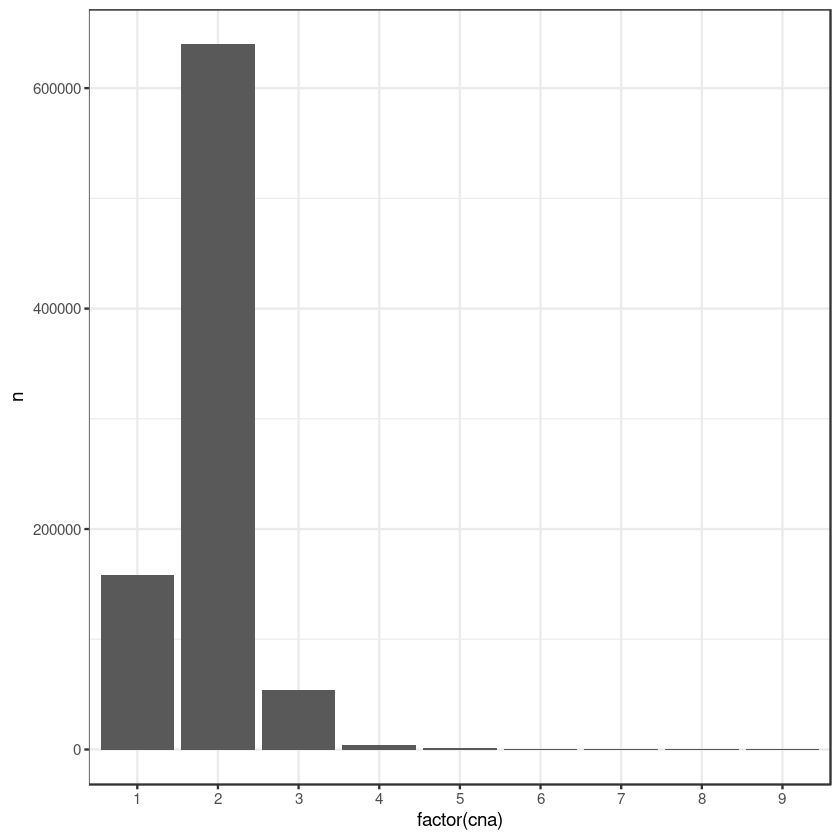

In [7]:
xist_cna <- get_xist_cna()
xist_cna %>% count(cna) %>% ggplot(aes(x=factor(cna), y=n)) + geom_col() + theme_bw()

Plotting the distribution of loci

#### Extended Data Figure 9D

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end", "samp")

Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Removed 2016 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2016 rows containing non-finite values (stat_signif).”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“Removed 2016 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2016 rows containing non-finite values (stat_signif).”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


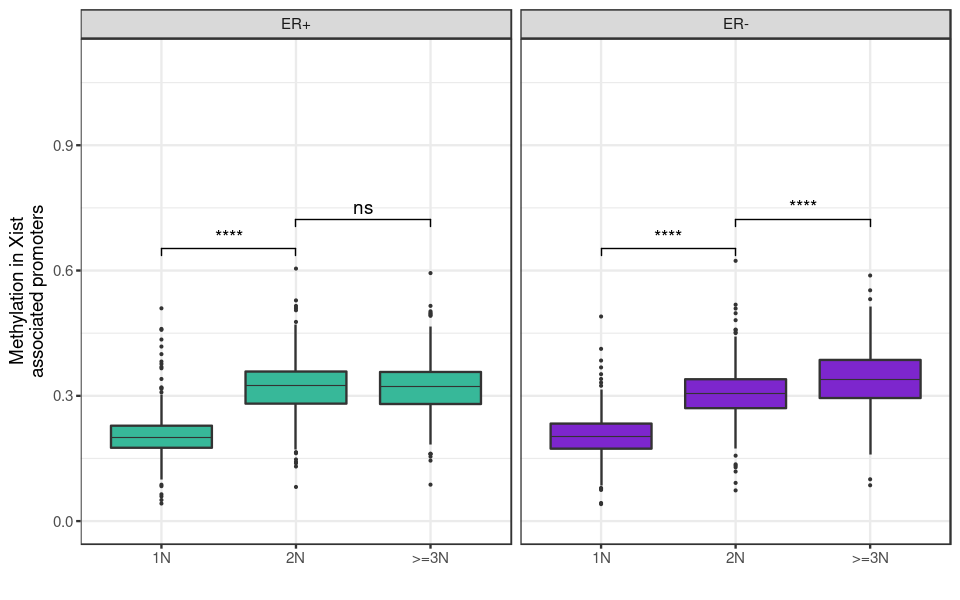

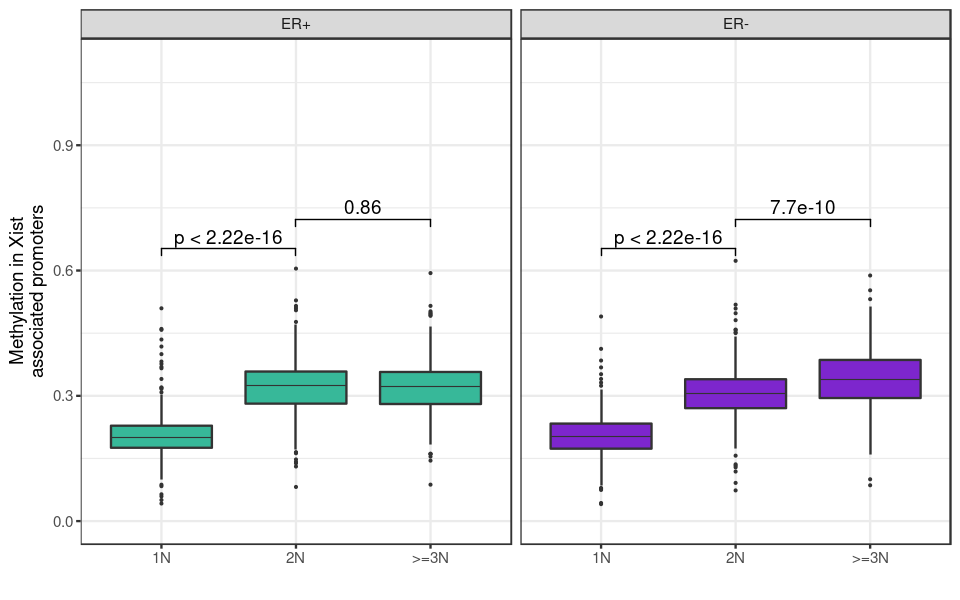

In [9]:
options(repr.plot.width = 8, repr.plot.height = 5)
df <- xist_cna %>%
    left_join(get_xist_loci_meth()) %>%
    group_by(cna_grp, ER, chrom, start, end) %>%
    summarise(meth = mean(meth, na.rm = TRUE)) %>%
    filter(!is.na(ER)) %>% 
    mutate(cna_grp = factor(cna_grp, levels = c("1N", "2N", ">=3N"))) %>% 
    mutate(ER = factor(ER, levels = c("ER+", "ER-")))
p_boxp_meth_cna <- df %>% 
    ggplot(aes(x = cna_grp, y = meth, fill = ER, group = cna_grp)) +
#     ggrastr::geom_boxplot_jitter(outlier.size = 0.1, outlier.jitter.width = 0.01, raster=TRUE) +
    geom_boxplot(linewidth=0.1, fatten=0.5, outlier.size=0.1) + 
    scale_fill_manual(values = annot_colors$ER1, guide = FALSE) +
    xlab("") +
    ylab("Methylation in Xist\nassociated promoters") +
    facet_grid(. ~ ER) +
    ylim(0, 1.1) + 
            theme(
                panel.grid.major.x = element_blank(),
                panel.grid.minor.x = element_blank()
            )
p_boxp_meth_cna  + ggpubr::stat_compare_means(label = "p.signif", comparisons = list(c("1N", "2N"), c("2N", ">=3N")))+ theme_bw()
p_boxp_meth_cna  + ggpubr::stat_compare_means(comparisons = list(c("1N", "2N"), c("2N", ">=3N")))+ theme_bw()

In [10]:
df %>% ungroup() %>% distinct(chrom, start, end, ER, cna_grp) %>% count(ER, cna_grp)

ER,cna_grp,n
<fct>,<fct>,<int>
ER+,1N,615
ER+,2N,615
ER+,>=3N,615
ER-,1N,615
ER-,2N,615
ER-,>=3N,615


In [11]:
xist_cna %>% distinct(cna_grp, samp, ER) %>% count(cna_grp, ER) 

cna_grp,ER,n
<fct>,<chr>,<int>
1N,ER-,181
1N,ER+,444
2N,ER-,269
2N,ER+,988
>=3N,ER-,135
>=3N,ER+,413


We now move to show scatters of loci in different CNA regimes

In [12]:
get_xist_meth_cna
xist_meth_cna <- get_xist_meth_cna()
head(xist_meth_cna)

function () 
{
    get_xist_cna() %>% inner_join(get_xist_loci_meth()) %>% group_by(chrom, 
        start, end, ER, cna_grp) %>% summarise(meth = mean(meth, 
        na.rm = TRUE)) %>% ungroup() %>% spread(cna_grp, meth)
}

Joining, by = "samp"

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end", "samp")



chrom,start,end,ER,1N,2N,>=3N
<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>
chrX,9983293,9983844,ER-,0.2078918,0.3067645,0.3205268
chrX,9983293,9983844,ER+,0.1944013,0.3302692,0.3235067
chrX,11683770,11684321,ER-,0.2001634,0.2802105,0.2939960
chrX,11683770,11684321,ER+,0.2885676,0.3238455,0.3123392
chrX,11776199,11776750,ER-,0.3316496,0.4977368,0.5313945
chrX,11776199,11776750,ER+,0.3403706,0.5048260,0.5023405


#### Extended Data Figure 9E

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


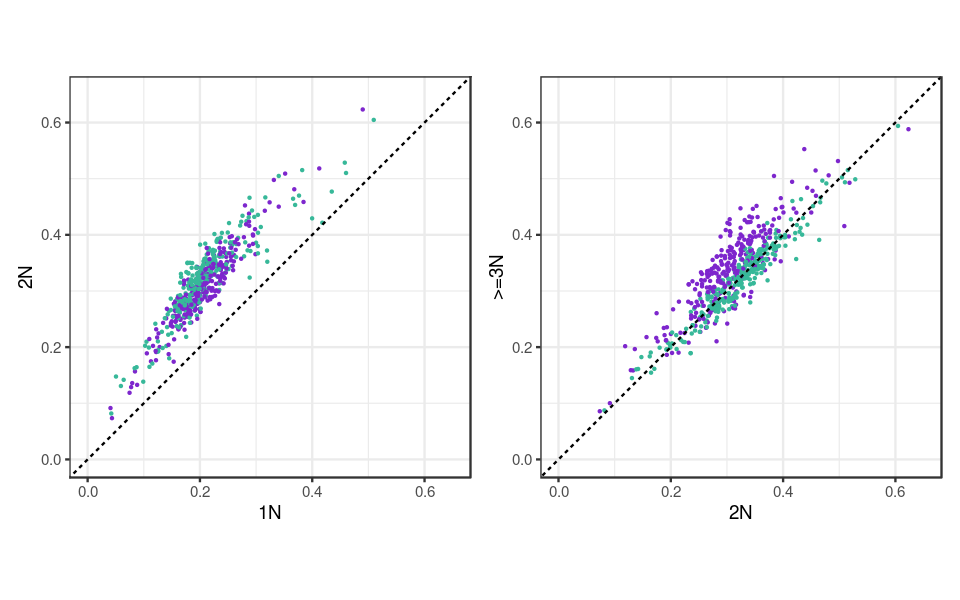

In [13]:
p_scatter_meth_cna_2_3 <- xist_meth_cna %>%
        ggplot(aes(x = `2N`, y = `>=3N`, color = ER)) +
#         ggrastr::geom_point_rast(size = 0.2, raster.width = 1, raster.height = 1) +
        geom_point(size=0.2) + 
        geom_abline(color = "black", linetype = "dashed") +
        scale_color_manual(values = annot_colors$ER1, guide = FALSE) +
        theme(aspect.ratio = 1) +
        xlim(0, 0.65) +
        ylim(0, 0.65) #+
#         annotate("text", x = 0.5, y = 0.1, label = paste("rho = ", round(cor(xist_meth_cna$`2N`, xist_meth_cna$`>=3N`, use = "pairwise.complete.obs"), digits = 3)), size = 2, family = "Arial")
p_scatter_meth_cna_1_2 <- xist_meth_cna %>%
        ggplot(aes(x = `1N`, y = `2N`, color = ER)) +
#         ggrastr::geom_point_rast(size = 0.2, raster.width = 1, raster.height = 1) +
        geom_point(size=0.2) + 
        geom_abline(color = "black", linetype = "dashed") +
        scale_color_manual(values = annot_colors$ER1, guide = FALSE) +
        theme(aspect.ratio = 1) +
        xlim(0, 0.65) +
        ylim(0, 0.65) #+
#         annotate("text", x = 0.5, y = 0.1, label = paste("rho = ", round(cor(xist_meth_cna$`1N`, xist_meth_cna$`2N`, use = "pairwise.complete.obs"), digits = 3)), size = 2, family = "Arial")
(p_scatter_meth_cna_1_2 + theme_bw() + theme(aspect.ratio = 1)) + (p_scatter_meth_cna_2_3 + theme_bw() + theme(aspect.ratio = 1))

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


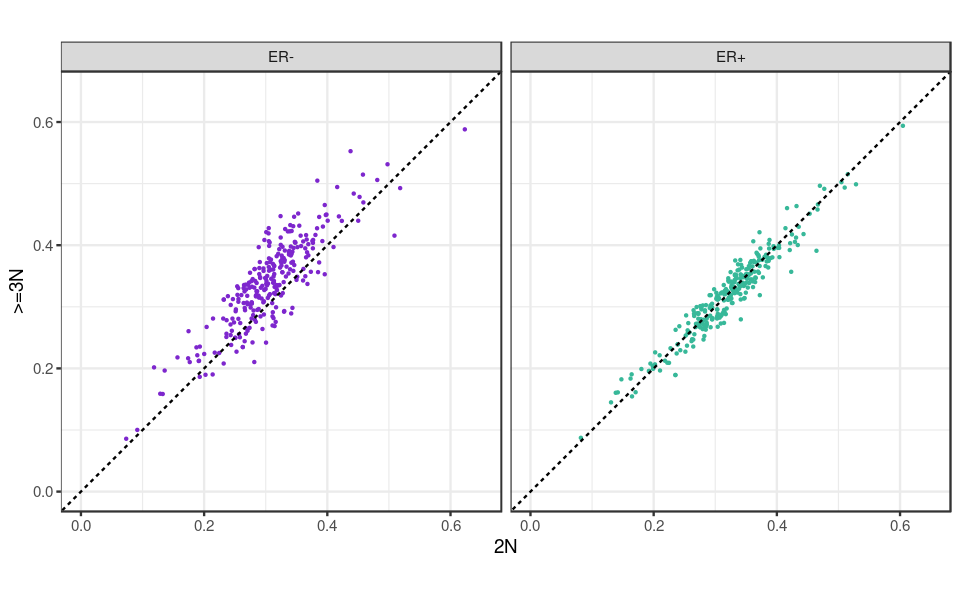

In [14]:
p_scatter_meth_cna_2_3 + facet_wrap(~ER) + theme_bw() + theme(aspect.ratio = 1) 

Same with expression:

In [15]:
get_xist_expr_cna
xist_expr_cna <- get_xist_expr_cna()
head(xist_expr_cna)

function () 
{
    get_xist_cna() %>% inner_join(get_xist_loci_expr()) %>% group_by(chrom, 
        start, end, ER, cna_grp) %>% summarise(expr = mean(expr, 
        na.rm = TRUE)) %>% ungroup() %>% spread(cna_grp, expr)
}

Joining, by = "samp"

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end", "samp")



chrom,start,end,ER,1N,2N,>=3N
<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>
chrX,9983293,9983844,ER-,7.880753,7.976930,8.193818
chrX,9983293,9983844,ER+,7.770670,7.811101,8.114064
chrX,14891025,14891576,ER-,7.175153,7.258638,7.427273
chrX,14891025,14891576,ER+,7.268545,7.233742,7.451081
chrX,14891133,14891684,ER-,6.111207,6.018312,6.172959
chrX,14891133,14891684,ER+,5.900340,5.859142,5.912923


#### Extended Data Figure 9F

Warning message:
“Removed 60 rows containing missing values (geom_point).”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“Removed 60 rows containing missing values (geom_point).”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


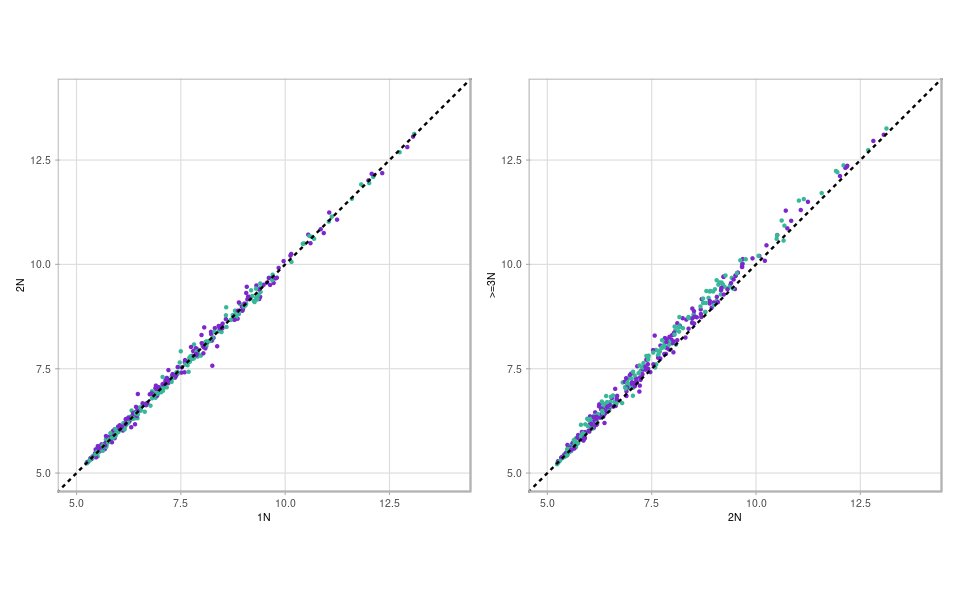

In [16]:
p_scatter_expr_cna_2_3 <- xist_expr_cna %>%
        ggplot(aes(x = `2N`, y = `>=3N`, color = ER)) +
        geom_point(size=0.2) + 
        geom_abline(color = "black", linetype = "dashed") +
        scale_color_manual(values = annot_colors$ER1, guide = FALSE) +
        theme(aspect.ratio = 1) +
        xlim(5, 14) +
        ylim(5, 14)

 p_scatter_expr_cna_1_2 <- xist_expr_cna %>% ggplot(aes(x = `1N`, y = `2N`, color = ER)) +
        geom_point(size=0.2) + 
        geom_abline(color = "black", linetype = "dashed") +
        scale_color_manual(values = annot_colors$ER1, guide = FALSE) +
        theme(aspect.ratio = 1) +
        xlim(5, 14) +
        ylim(5, 14) 

p_scatter_expr_cna_1_2 + p_scatter_expr_cna_2_3

## autosome analysis

In [17]:
get_autosome_loci
autosome_loci <- get_autosome_loci()

function () 
{
    get_promoter_avg_meth() %>% select(chrom, start, end) %>% 
        filter(chrom != "chrX", chrom != "chrY") %>% anti_join(get_xist_loci(), 
        by = c("chrom", "start", "end"))
}

In [18]:
get_autosome_cna
autosome_cna <- get_autosome_cna()
head(autosome_cna)

function () 
{
    {
        autosome_cna <- get_autosome_loci() %>% gintervals.neighbors1(cna %>% 
            mutate(end = ifelse(start == end, start + 1, end)) %>% 
            filter(chrom != "chrX"), maxneighbors = nrow(samp_data)) %>% 
            filter(dist == 0) %>% select(chrom, start, end, samp, 
            cna = cna_round)
        autosome_cna <- autosome_cna %>% mutate(cna_grp = cut(cna, 
            breaks = c(-1, 0, 1, 2, 10), labels = c("0N", "1N", 
                "2N", ">=3N"))) %>% filter(cna_grp != "0N") %>% 
            left_join(samp_data %>% select(samp, ER = ER1))
        autosome_cna
    } %cache_df% here("data/autosome_cna.tsv") %>% as_tibble()
}

Joining, by = "samp"



chrom,start,end,samp,cna,cna_grp,ER
<chr>,<int>,<int>,<chr>,<int>,<fct>,<chr>
chr1,762469,763020,MB_0006,2,2N,ER+
chr1,762469,763020,MB_0028,1,1N,ER+
chr1,762469,763020,MB_0035,2,2N,ER-
chr1,762469,763020,MB_0046,2,2N,ER+
chr1,762469,763020,MB_0050,2,2N,ER+
chr1,762469,763020,MB_0053,1,1N,ER+


In [19]:
get_autosome_loci_meth
autosome_loci_meth <- get_autosome_loci_meth()
head(autosome_loci_meth)

function () 
{
    get_autosome_loci() %>% inner_join(get_promoter_avg_meth()) %>% 
        gather("samp", "meth", -(chrom:end))
}

Joining, by = c("chrom", "start", "end")



,chrom,start,end,samp,meth
,<chr>,<int>,<int>,<chr>,<dbl>
1,chr1,762469,763020,MB_0006,0.000000000
2,chr1,762676,763227,MB_0006,0.021929825
3,chr1,860619,861170,MB_0006,0.001870324
4,chr1,895465,896016,MB_0006,0.014367816
5,chr1,901375,901926,MB_0006,0.024253731
6,chr1,948345,948896,MB_0006,0.000000000


Plotting the distribution of loci

#### Extended Data Figure 9G

Joining, by = c("chrom", "start", "end", "samp")

Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Removed 6 rows containing missing values (geom_signif).”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“Removed 6 rows containing missing values (geom_signif).”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


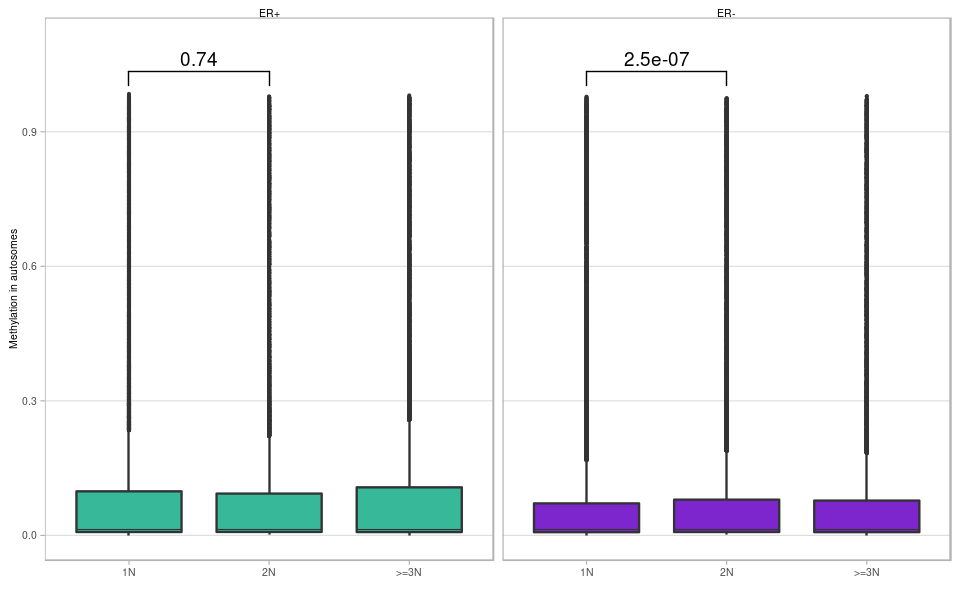

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


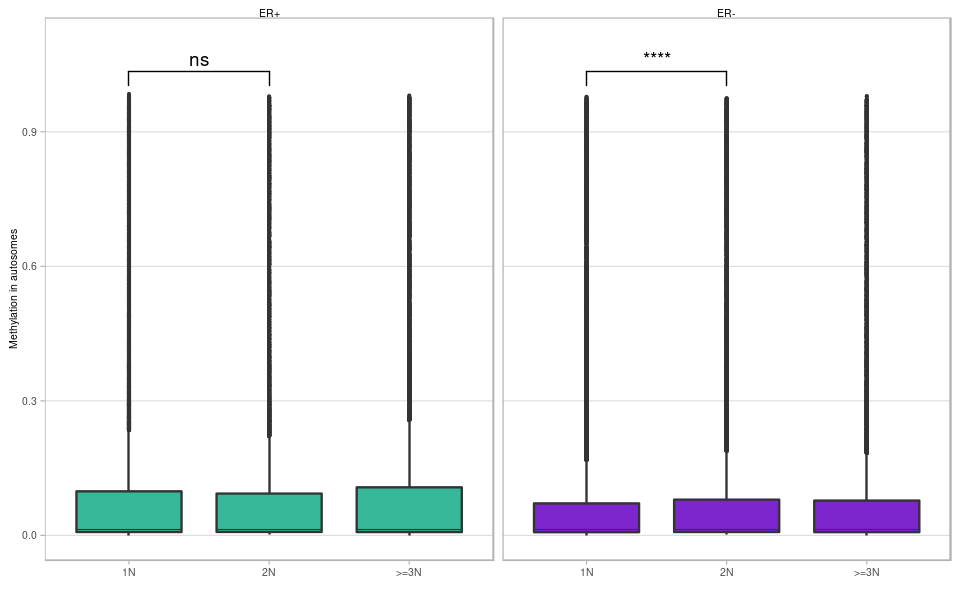

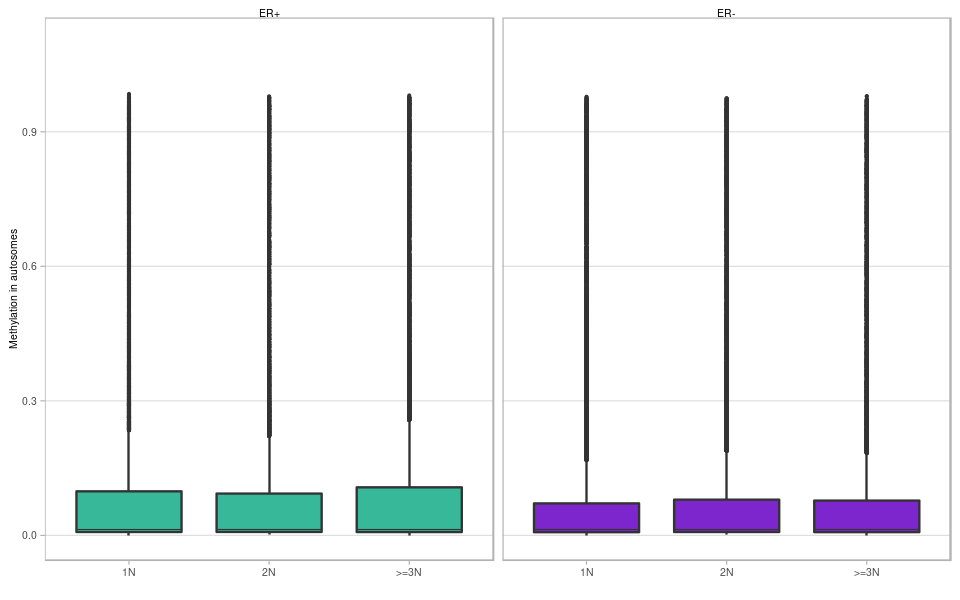

In [20]:
options(repr.plot.width = 8, repr.plot.height = 5)
df <- autosome_cna %>%
    left_join(autosome_loci_meth) %>%
    group_by(cna_grp, ER, chrom, start, end) %>%
    summarise(meth = mean(meth, na.rm = TRUE)) %>%
    filter(!is.na(ER)) %>% 
    mutate(cna_grp = factor(cna_grp, levels = c("1N", "2N", ">=3N"))) %>% 
    mutate(ER = factor(ER, levels = c("ER+", "ER-")))
p_boxp_meth_cna_autosome <- df %>% 
    ggplot(aes(x = cna_grp, y = meth, fill = ER, group = cna_grp)) +
#     ggrastr::geom_boxplot_jitter(outlier.size = 0.1, outlier.jitter.width = 0.01, raster=TRUE) + 
    geom_boxplot(linewidth=0.1, fatten=0.5, outlier.size = 0.1) + 
    scale_fill_manual(values = annot_colors$ER1, guide = FALSE) +
    xlab("") +
    ylab("Methylation in autosomes") +
    facet_grid(. ~ ER) +
    ylim(0, 1.1) + 
            theme(
                panel.grid.major.x = element_blank(),
                panel.grid.minor.x = element_blank()
            )

p_boxp_meth_cna_autosome + ggpubr::stat_compare_means(comparisons = list(c("1N", "2N"), c("2N", ">=3N")))
p_boxp_meth_cna_autosome +
     ggpubr::stat_compare_means(label = "p.signif", comparisons = list(c("1N", "2N"), c("2N", ">=3N"))) 
p_boxp_meth_cna_autosome

In [21]:
df %>% ungroup() %>% distinct(chrom, start, end, ER) %>% count(ER)

ER,n
<fct>,<int>
ER+,15207
ER-,15207


In [22]:
autosome_cna %>% distinct(cna_grp, samp, ER) %>% count(ER, cna_grp)

ER,cna_grp,n
<chr>,<fct>,<int>
ER-,1N,278
ER-,2N,293
ER-,>=3N,296
ER+,1N,1060
ER+,2N,1085
ER+,>=3N,1077


We now move to show scatters of loci in different CNA regimes

In [23]:
get_autosome_meth_cna
autosome_meth_cna <- get_autosome_meth_cna()
head(autosome_meth_cna)

function () 
{
    {
        auto_df <- get_autosome_cna() %>% inner_join(get_autosome_loci_meth()) %>% 
            group_by(chrom, start, end, ER, cna_grp) %>% summarise(meth = mean(meth, 
            na.rm = TRUE)) %>% ungroup() %>% spread(cna_grp, 
            meth)
        auto_df
    } %cache_df% here("data/autosome_meth_cna.tsv") %>% as_tibble()
}

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end", "samp")



chrom,start,end,ER,>=3N,1N,2N
<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>
chr1,762469,763020,ER-,0.007852706,0.008341878,0.007857689
chr1,762469,763020,ER+,0.006506879,0.008089050,0.008125402
chr1,762676,763227,ER-,0.028412915,0.021358769,0.026941446
chr1,762676,763227,ER+,0.028590166,0.070967669,0.042346185
chr1,762851,763402,ER-,0.029766663,0.022340914,0.029069381
chr1,762851,763402,ER+,0.032413643,0.078736553,0.047128295


#### Extended Data Figure 9H

Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


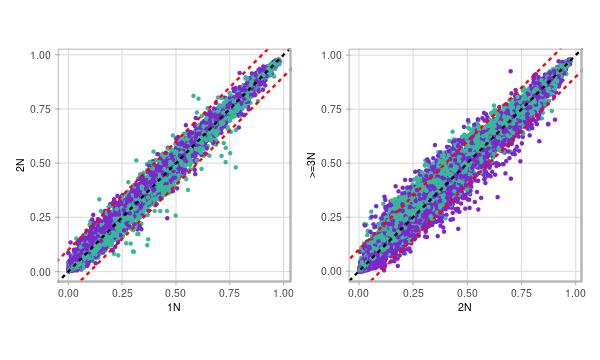

In [24]:
options(repr.plot.width = 5, repr.plot.height = 3)
p_scatter_meth_cna_2_3_autosome <- autosome_meth_cna %>%
        ggplot(aes(x = `2N`, y = `>=3N`, color = ER)) +
        geom_point(size=0.2) + 
        geom_abline(color = "black", linetype = "dashed") +
        scale_color_manual(values = annot_colors$ER1, guide = FALSE) +
        geom_abline(color = "red", linetype = "dashed", intercept = 0.1) + 
        geom_abline(color = "red", linetype = "dashed", intercept = -0.1) + 
        theme(aspect.ratio = 1)
p_scatter_meth_cna_1_2_autosome <- autosome_meth_cna %>%
        ggplot(aes(x = `1N`, y = `2N`, color = ER)) +
        geom_point(size=0.2) + 
        geom_abline(color = "black", linetype = "dashed") +
        scale_color_manual(values = annot_colors$ER1, guide = FALSE) +        
        geom_abline(color = "red", linetype = "dashed", intercept = 0.1) + 
        geom_abline(color = "red", linetype = "dashed", intercept = -0.1) +
        theme(aspect.ratio = 1)          
        
p_scatter_meth_cna_1_2_autosome + p_scatter_meth_cna_2_3_autosome

Same with expression:

In [25]:
get_autosome_expr_cna
autosome_expr_cna <- get_autosome_expr_cna()
head(autosome_expr_cna)

function () 
{
    {
        auto_df <- get_autosome_cna() %>% inner_join(get_autosome_loci_expr()) %>% 
            group_by(chrom, start, end, ER, cna_grp) %>% summarise(expr = mean(expr, 
            na.rm = TRUE)) %>% ungroup() %>% spread(cna_grp, 
            expr)
        auto_df
    } %cache_df% here("data/autosome_expr_cna.tsv") %>% as_tibble()
}

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end", "samp")



chrom,start,end,ER,>=3N,1N,2N
<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>
chr1,762469,763020,ER-,NaN,NaN,NaN
chr1,762469,763020,ER+,NaN,NaN,NaN
chr1,762851,763402,ER-,NaN,NaN,NaN
chr1,762851,763402,ER+,NaN,NaN,NaN
chr1,860619,861170,ER-,5.598424,5.685151,5.844717
chr1,860619,861170,ER+,5.816428,5.804565,5.811422


Warning message:
“Removed 5366 rows containing missing values (geom_point).”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“Removed 5369 rows containing missing values (geom_point).”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


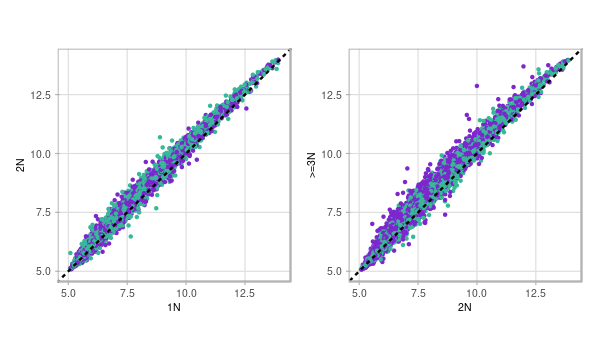

In [26]:
p_scatter_expr_cna_2_3 <- autosome_expr_cna %>%
        ggplot(aes(x = `2N`, y = `>=3N`, color = ER)) +
        geom_point(size=0.2) + 
        geom_abline(color = "black", linetype = "dashed") +
        scale_color_manual(values = annot_colors$ER1, guide = FALSE) +
        theme(aspect.ratio = 1) +
        xlim(5, 14) +
        ylim(5, 14)

 p_scatter_expr_cna_1_2 <- autosome_expr_cna %>% ggplot(aes(x = `1N`, y = `2N`, color = ER)) +
        geom_point(size=0.2) + 
        geom_abline(color = "black", linetype = "dashed") +
        scale_color_manual(values = annot_colors$ER1, guide = FALSE) +
        theme(aspect.ratio = 1) +
        xlim(5, 14) +
        ylim(5, 14) 

p_scatter_expr_cna_1_2 + p_scatter_expr_cna_2_3

Looking at the distribution of loci in 2N / >=3N (averaging the samples expression per ER and CNA)

In [27]:
get_xist_expr_cna
get_autosome_expr_cna
df_fc <- get_xist_expr_cna() %>%
        mutate(type = "X") %>%
        bind_rows(get_autosome_expr_cna() %>% mutate(type = "auto")) %>%
        mutate(diff = `>=3N` - `2N`, diff1 = `2N` - `1N`) %>%
#         filter(ER == "ER+")
        filter(ER == "ER-")
head(df_fc)

function () 
{
    get_xist_cna() %>% inner_join(get_xist_loci_expr()) %>% group_by(chrom, 
        start, end, ER, cna_grp) %>% summarise(expr = mean(expr, 
        na.rm = TRUE)) %>% ungroup() %>% spread(cna_grp, expr)
}

function () 
{
    {
        auto_df <- get_autosome_cna() %>% inner_join(get_autosome_loci_expr()) %>% 
            group_by(chrom, start, end, ER, cna_grp) %>% summarise(expr = mean(expr, 
            na.rm = TRUE)) %>% ungroup() %>% spread(cna_grp, 
            expr)
        auto_df
    } %cache_df% here("data/autosome_expr_cna.tsv") %>% as_tibble()
}

Joining, by = "samp"

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end", "samp")



chrom,start,end,ER,1N,2N,>=3N,type,diff,diff1
<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
chrX,9983293,9983844,ER-,7.880753,7.976930,8.193818,X,0.216887405,0.09617691
chrX,14891025,14891576,ER-,7.175153,7.258638,7.427273,X,0.168634811,0.08348508
chrX,14891133,14891684,ER-,6.111207,6.018312,6.172959,X,0.154646592,-0.09289491
chrX,15353625,15354176,ER-,7.884146,7.926416,8.264637,X,0.338220886,0.04227070
chrX,16964312,16964863,ER-,6.916974,7.004652,7.381009,X,0.376356425,0.08767872
chrX,17393041,17393592,ER-,6.256066,6.338770,6.347885,X,0.009114449,0.08270411


#### Extended Data Figure 9I

2.47357689886485e-12

Warning message:
“Removed 2710 rows containing non-finite values (stat_density).”


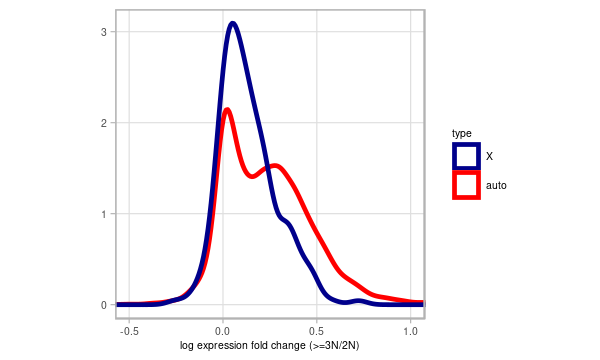

In [28]:
pval <- ks.test(df_fc$diff[df_fc$type == "X"], df_fc$diff[df_fc$type == "auto"])$p.value
message(pval)

fc_p <- df_fc %>%
        ggplot(aes(color = type, x = diff)) +
        geom_density(size = 1) +
        theme(aspect.ratio = 1) +
        xlab("log expression fold change (>=3N/2N)") +
        ylab("") +
        scale_color_manual(values = c("X" = "darkblue", "auto" = "red")) +
        coord_cartesian(xlim = c(-0.5, 1)) +
        theme(aspect.ratio = 1) 
#         annotate("text", x = 0.5, y = 4, label = "p<<0.001 (KS)", size = 2, family = "Arial")

fc_p

0

Warning message:
“Removed 2710 rows containing non-finite values (stat_density).”


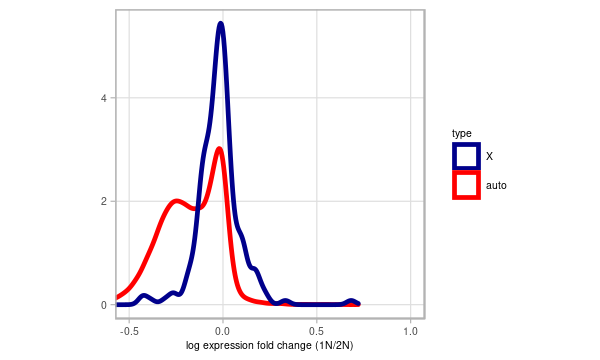

In [29]:
pval <- ks.test(df_fc$diff1[df_fc$type == "X"], df_fc$diff1[df_fc$type == "auto"])$p.value
message(pval)

fc_p <- df_fc %>%
        ggplot(aes(color = type, x = -diff1)) +
        geom_density(size = 1) +
        theme(aspect.ratio = 1) +
        xlab("log expression fold change (1N/2N)") +
        ylab("") +
        scale_color_manual(values = c("X" = "darkblue", "auto" = "red")) +
        coord_cartesian(xlim = c(-0.5, 1)) +
        theme(aspect.ratio = 1) 
#         annotate("text", x = 0.5, y = 4, label = "p<<0.001 (KS)", size = 2, family = "Arial")

fc_p

In [30]:
head(df_fc)

chrom,start,end,ER,1N,2N,>=3N,type,diff,diff1
<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
chrX,9983293,9983844,ER-,7.880753,7.976930,8.193818,X,0.216887405,0.09617691
chrX,14891025,14891576,ER-,7.175153,7.258638,7.427273,X,0.168634811,0.08348508
chrX,14891133,14891684,ER-,6.111207,6.018312,6.172959,X,0.154646592,-0.09289491
chrX,15353625,15354176,ER-,7.884146,7.926416,8.264637,X,0.338220886,0.04227070
chrX,16964312,16964863,ER-,6.916974,7.004652,7.381009,X,0.376356425,0.08767872
chrX,17393041,17393592,ER-,6.256066,6.338770,6.347885,X,0.009114449,0.08270411


Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end", "samp")

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end", "samp")

Joining, by = c("chrom", "start", "end", "ER")

Joining, by = c("chrom", "start", "end", "ER")

Joining, by = c("chrom", "start", "end", "ER")

Joining, by = c("chrom", "start", "end")

Joining, by = "samp"

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end", "samp")

Joining, by = c("chrom", "start", "end", "ER", ">=3N", "1N", "2N")

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message in ks.test(diff[type == "auto-dosage"], diff[type == "auto"]):
“p-value will be approximate in the presence of ties”
Warning message in ks.test(diff[type == "auto-dosage"], diff[type == "auto"]):
“p-value will be approximate in the presence of ties”


# A tibble: 2 x 3
   ER     p_x_auto p_auto_dosage
1 ER+ 8.098625e-03             0
2 ER- 2.473577e-12             0


Joining, by = "samp"

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end", "samp")

Joining, by = c("chrom", "start", "end", "ER", "1N", "2N")

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message in ks.test(diff[type == "auto-dosage"], diff[type == "auto"]):
“p-value will be approximate in the presence of ties”


# A tibble: 2 x 3
   ER p_x_auto p_auto_dosage
1 ER+        0   0.025359716
2 ER-        0   0.006938004


Warning message:
“Removed 5602 rows containing non-finite values (stat_density).”
Warning message:
“Removed 5448 rows containing non-finite values (stat_density).”


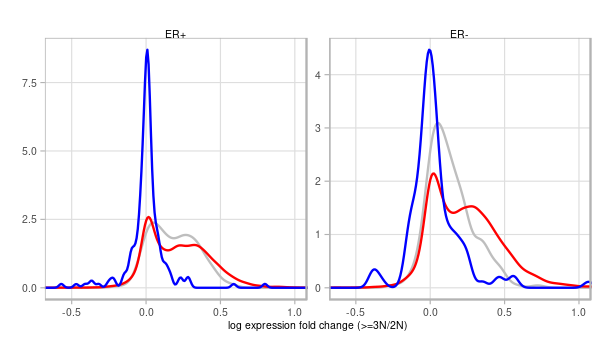

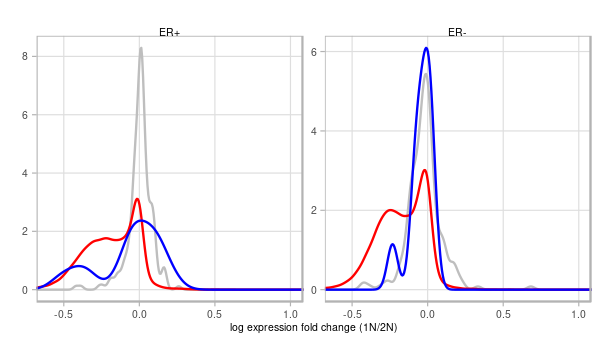

In [31]:
thresh <- 0.1
autosome_cna_meth_expr <- get_autosome_cna_meth_expr()
    dosage_cands <- autosome_cna_meth_expr %>% 
        filter(`>=3N` >= (`2N` + thresh) ) %>%         
        filter(`n_>=3N` >= 5, `n_2N` >= 5) 

    dosage_cands_1N <- autosome_cna_meth_expr %>% 
        filter(`1N` <= (`2N` - thresh) ) %>%         
        filter(`n_1N` >= 5, `n_2N` >= 5)     

    dosage_cands_expr <- dosage_cands %>% select(chrom, start, end, ER, `1N` = `expr_1N`, `2N` = `expr_2N`, `>=3N` = `expr_>=3N`)
    dosage_cands_expr_1N <- dosage_cands_1N %>% select(chrom, start, end, ER, `1N` = `expr_1N`, `2N` = `expr_2N`)

    df_fc <- get_xist_expr_cna() %>%
        mutate(type = "X") %>%
        bind_rows(autosome_expr_cna %>% anti_join(dosage_cands_expr) %>% mutate(type = "auto")) %>%
        bind_rows(dosage_cands_expr %>% mutate(type = "auto-dosage")) %>% 
        mutate(ER = factor(ER, levels=c("ER+", "ER-"))) %>%
        filter(!is.na(ER)) %>% 
        mutate(type = factor(type, levels=c("X", "auto", "auto-dosage"))) %>%
        arrange(type) %>%
        mutate(diff = `>=3N` - `2N`) 

    fc_p <- df_fc %>%
        ggplot(aes(color = type, x = diff)) +
        geom_density(size = 0.5) +
        theme(aspect.ratio = 1) +
        xlab("log expression fold change (>=3N/2N)") +
        ylab("") +
        scale_color_manual(values = c("auto" = "red", "auto-dosage" = "blue", "X" = "gray")) + 
        # ggsci::scale_color_npg() +         
        coord_cartesian(xlim = c(-0.6, 1)) +
        theme(aspect.ratio = 1) + 
        facet_wrap(~ER, scale="free_y", nrow=1) + 
        guides(color = FALSE)

    df_fc %>% group_by(ER) %>% summarise(p_x_auto = ks.test(diff[type == "X"], diff[type == "auto"])$p.value, p_auto_dosage =  ks.test(diff[type == "auto-dosage"], diff[type == "auto"])$p.value) %>% print()

    df_fc_1N <- get_xist_expr_cna() %>%
        mutate(type = "X") %>%
        bind_rows(autosome_expr_cna %>% anti_join(dosage_cands_expr_1N) %>% mutate(type = "auto")) %>%
        bind_rows(dosage_cands_expr_1N %>% mutate(type = "auto-dosage")) %>% 
        mutate(ER = factor(ER, levels=c("ER+", "ER-"))) %>%
        filter(!is.na(ER)) %>% 
        mutate(type = factor(type, levels=c("X", "auto", "auto-dosage"))) %>%
        arrange(type) %>%
        mutate(diff = `1N` - `2N`) 

    fc_p_1N <- df_fc_1N %>%
        ggplot(aes(color = type, x = diff)) +
        geom_density(size = 0.5) +
        theme(aspect.ratio = 1) +
        xlab("log expression fold change (1N/2N)") +
        ylab("") +
        scale_color_manual(values = c("auto" = "red", "auto-dosage" = "blue", "X" = "gray")) +           
        coord_cartesian(xlim = c(-0.6, 1)) +
        theme(aspect.ratio = 1) + 
        facet_wrap(~ER, scale="free_y", nrow=1) + 
        guides(color = FALSE)

    df_fc_1N %>% group_by(ER) %>% summarise(p_x_auto = ks.test(diff[type == "X"], diff[type == "auto"])$p.value, p_auto_dosage =  ks.test(diff[type == "auto-dosage"], diff[type == "auto"])$p.value) %>% print() 

fc_p
fc_p_1N

## Checking dosage compensation on all X loci

In [32]:
get_xist_loci

function () 
{
    {
        xist_expr <- get_gene_expression_mat() %>% filter(name == 
            "XIST") %>% gather("samp", "expr", -(chrom:name3.chr)) %>% 
            as_tibble()
        all_norm_meth <- fread(here("data/all_norm_meth.tsv")) %>% 
            filter(chrom == "chrX") %>% as_tibble()
        ER_positive_mat <- all_norm_meth %>% select(chrom:end, 
            any_of(ER_positive_samples)) %>% intervs_to_mat()
        ER_negative_mat <- all_norm_meth %>% select(chrom:end, 
            any_of(ER_negative_samples)) %>% intervs_to_mat()
        xist_expr_vec <- xist_expr %>% select(samp, expr) %>% 
            deframe()
        samples <- intersect(names(xist_expr_vec), colnames(ER_positive_mat))
        ER_pos_cors <- tgs_cor(t(ER_positive_mat[, samples]), 
            as.matrix(xist_expr_vec[samples]), pairwise.complete.obs = TRUE)
        samples <- intersect(names(xist_expr_vec), colnames(ER_negative_mat))
        ER_neg_cors <- tgs_cor(t(ER_negative_mat[, samples]), 
            as.matrix(xist_expr_vec[samples]), pairwise.complete.obs = TRUE)
        xist_loci <- cbind(ER_pos_cors, ER_neg_cors) %>% mat_to_intervs() %>% 
            filter(V1 >= 0.2 | V2 >= 0.2) %>% distinct(chrom, 
            start, end)
    } %cache_df% here("data/xist_loci.tsv") %>% as_tibble()
}
<bytecode: 0x135a1888>

In [33]:
all_norm_meth_x <- fread(here("data/all_norm_meth.tsv")) %>% 
            filter(chrom == "chrX") %>% as_tibble()
X_loci <- all_norm_meth_x %>% distinct(chrom, start, end)

In [34]:
get_xist_cna

function () 
{
    xist_cna <- get_xist_loci() %>% gintervals.neighbors1(cna %>% 
        mutate(end = ifelse(start == end, start + 1, end)) %>% 
        filter(chrom == "chrX"), maxneighbors = nrow(samp_data)) %>% 
        filter(dist == 0) %>% select(chrom, start, end, samp, 
        cna = cna_round)
    xist_cna <- xist_cna %>% mutate(cna_grp = cut(cna, breaks = c(-1, 
        0, 1, 2, 10), labels = c("0N", "1N", "2N", ">=3N"))) %>% 
        filter(cna_grp != "0N") %>% left_join(samp_data %>% select(samp, 
        ER = ER1))
    return(xist_cna)
}
<bytecode: 0x140722b8>

In [35]:
X_cna <- X_loci %>% gintervals.neighbors1(cna %>% 
    mutate(end = ifelse(start == end, start + 1, end)) %>% 
    filter(chrom == "chrX"), maxneighbors = nrow(samp_data)) %>% 
    filter(dist == 0) %>% select(chrom, start, end, samp, 
    cna = cna_round)
X_cna <- X_cna %>% mutate(cna_grp = cut(cna, breaks = c(-1, 
        0, 1, 2, 10), labels = c("0N", "1N", "2N", ">=3N"))) %>% 
        filter(cna_grp != "0N") %>% left_join(samp_data %>% select(samp, 
        ER = ER1)) %cache_df% here("data/X_cna.tsv") %>% as_tibble()
head(X_cna)

Joining, by = "samp"



chrom,start,end,samp,cna,cna_grp,ER
<chr>,<int>,<int>,<chr>,<int>,<fct>,<chr>
chrX,192489,193040,MB_0006,2,2N,ER+
chrX,192489,193040,MB_0028,1,1N,ER+
chrX,192489,193040,MB_0046,1,1N,ER+
chrX,192489,193040,MB_0050,1,1N,ER+
chrX,192489,193040,MB_0053,1,1N,ER+
chrX,192489,193040,MB_0054,2,2N,ER+


In [36]:
get_xist_loci_meth

function () 
{
    get_xist_loci() %>% inner_join(get_promoter_avg_meth()) %>% 
        gather("samp", "meth", -(chrom:end))
}
<bytecode: 0x58cfbaa8>

In [37]:
X_loci_meth <- X_loci %>% inner_join(get_promoter_avg_meth()) %>% 
        gather("samp", "meth", -(chrom:end))

Joining, by = c("chrom", "start", "end")



Joining, by = c("chrom", "start", "end", "samp")

Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Removed 41928 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 41928 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 6 rows containing missing values (geom_signif).”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


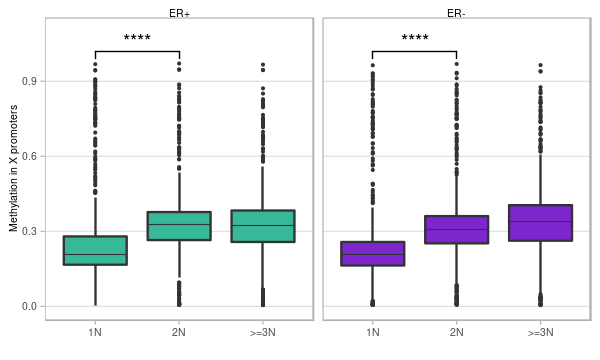

In [38]:
options(repr.plot.width = 5, repr.plot.height = 3)
p_boxp_meth_cna_all <- X_cna %>%
    left_join(X_loci_meth) %>%
    group_by(cna_grp, ER, chrom, start, end) %>%
    summarise(meth = mean(meth, na.rm = TRUE)) %>%
    filter(!is.na(ER)) %>% 
    mutate(cna_grp = factor(cna_grp, levels = c("1N", "2N", ">=3N"))) %>% 
    mutate(ER = factor(ER, levels = c("ER+", "ER-"))) %>% 
    ggplot(aes(x = cna_grp, y = meth, fill = ER, group = cna_grp)) +
    geom_boxplot(linewidth=0.1, fatten=0.5, outlier.size = 0.1) + 
    scale_fill_manual(values = annot_colors$ER1, guide = FALSE) +
    xlab("") +
    ylab("Methylation in X promoters") +
    facet_grid(. ~ ER) +
    ylim(0, 1.1) +
    ggpubr::stat_compare_means(label = "p.signif", comparisons = list(c("1N", "2N"), c("2N", ">=3N"))) + 
            theme(
                panel.grid.major.x = element_blank(),
                panel.grid.minor.x = element_blank()
            )
p_boxp_meth_cna_all

> Looks very similar to the XIST associated version

## % of X lost

#### Extended Data Figure 9C

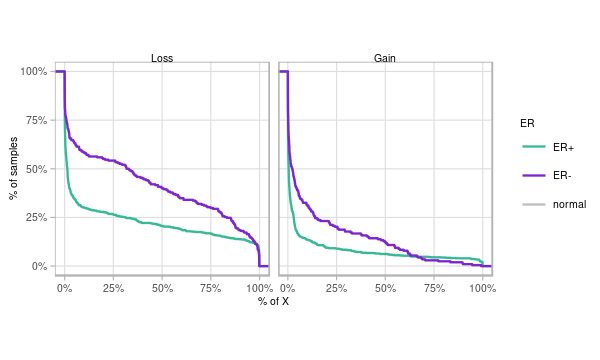

In [39]:
chr_x_len <- gintervals.all() %>% filter(chrom == "chrX") %>% pull(end)
p_x_perc <- cna %>% 
    filter(chrom == "chrX") %>% mutate(l = end - start) %>% 
    mutate(cna = cut(cna_round, breaks = c(0, 1, 2, 20), include.lowest=TRUE, labels=c("Loss", "normal", "Gain"))) %>% 
    group_by(samp, cna) %>% 
    summarise(p = sum(l) / chr_x_len) %>% 
    filter(cna != "normal") %>% 
    ungroup() %>% 
    add_ER() %>% 
    filter(!is.na(ER)) %>% 
    ggplot(aes(x=p, color=ER, y=1-..y..)) + 
        stat_ecdf() + 
        facet_wrap(~cna) + 
        scale_color_manual(values=annot_colors$ER1) + 
        theme(aspect.ratio=1) + 
        xlab("% of X") + 
        ylab("% of samples") + 
        scale_x_continuous(labels=scales::percent) + 
        scale_y_continuous(labels=scales::percent)
p_x_perc

## Plot Expression-Methylation correlation for X

In [40]:
meth_mat <- all_norm_meth_x %>% select(chrom:end, any_of(ER_positive_samples)) %>% intervs_to_mat()

In [41]:
expr_m <- get_gene_expression_mat() %>% select(-any_of(c("chrom", "start", "end", "name3.chr")))
expr_mat <- expr_m %>%
    as.data.frame() %>%
    column_to_rownames("name")
f <- rowSums(!is.na(expr_mat)) > 0
expr_mat <- expr_mat[f, ]
dim(expr_mat)

[1] 17691  2124

In [42]:
em_cross <- em_cross_cor(meth_mat, expr_mat, meth_cor_thresh = 0.25, expr_cor_thresh = 0.25) %cache_rds% here("data/X_er_positive_em_cross_cor.rds")

# of samples: 1108

expression (columns): 17691

methylation (rows): 7474

1218 rows had at least one cor > 0.25

595 columns had at least one cor > 0.25



In [43]:
em_cross_clust <- cluster_em_cross_cor(em_cross, k_meth = 32, k_expr = 32) %cache_rds% here("data/X_er_positive_em_cross_cor_clust.rds")

#### Extended Data Figure 9A

plotting em cross



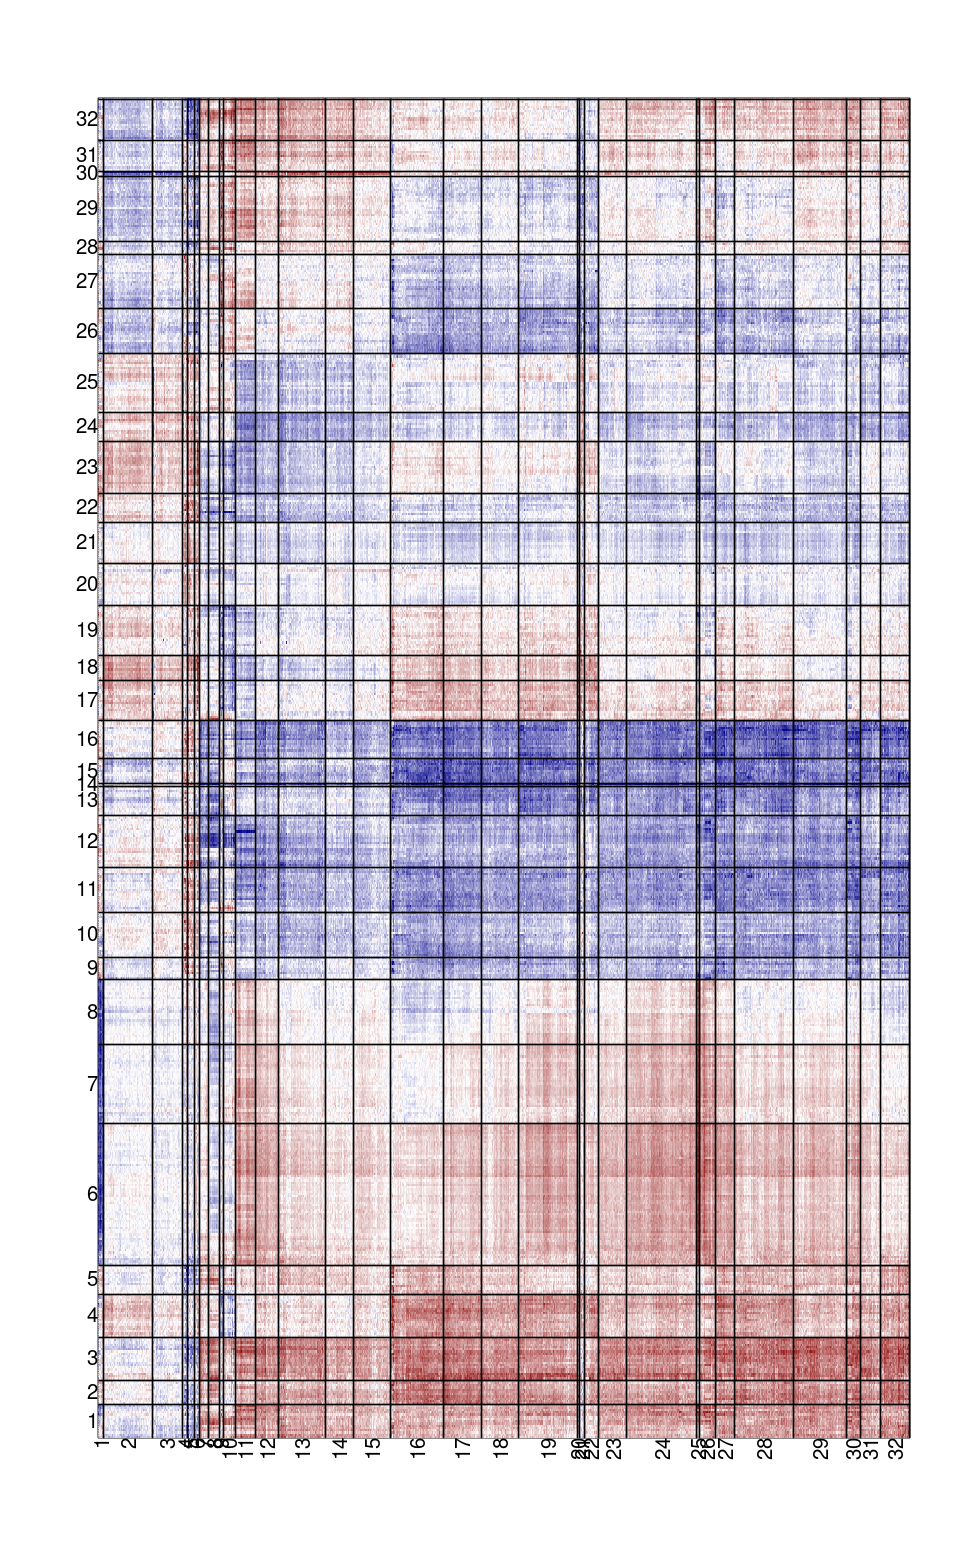

In [44]:
options(repr.plot.width = 8, repr.plot.height = 13)
plot_em_cross_cor(em_cross_clust)

In [45]:
em_cross_clust$em_cross[1:5, 1:5]

,AARS,ABCA6,ABCA8,ABCB1,ABI3BP
chrX_12156083_12156634,-0.009473256,0.069027019,0.089264904,0.014470847,0.089861306
chrX_14261885_14262436,-0.029288914,-0.007331325,-0.003098204,-0.054763278,-0.001929155
chrX_23017576_23018127,0.091659895,-0.029980425,-0.017798906,-0.016557969,-0.010672580
chrX_23800773_23801324,-0.142085957,0.028894237,0.062800268,-0.001669589,0.016375597
chrX_23925621_23926172,-0.080076720,-0.025302800,0.012101469,0.012796371,-0.010378608


In [46]:
dim(em_cross_clust$em_cross)

[1] 1218  595

# Finding specific dosage compensation examples

In [47]:
autosome_cands_3n <- get_autosome_dosage_comp_cands("3N")
head(autosome_cands_3n)

Joining, by = "samp"

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end", "samp")

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end", "samp")

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end", "samp")

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end", "samp")

Joining, by = c("chrom", "start", "end", "ER")

Joining, by = c("chrom", "start", "end", "ER")

Joining, by = c("chrom", "start", "end", "ER")

Joining, by = c("chrom", "start", "end")



chrom,start,end,ER,1N,2N,>=3N,n_>=3N,n_1N,n_2N,expr_>=3N,expr_1N,expr_2N,n_expr_>=3N,n_expr_1N,n_expr_2N,name
<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>
chr1,762469,763020,ER-,0.008341878,0.007857689,0.007852706,15,60,210,NaN,NaN,NaN,NA,NA,NA,LINC01128
chr1,762469,763020,ER+,0.008089050,0.008125402,0.006506879,12,211,816,NaN,NaN,NaN,NA,NA,NA,LINC01128
chr1,762676,763227,ER-,0.021358769,0.026941446,0.028412915,16,67,220,NA,NA,NA,NA,NA,NA,NA
chr1,762676,763227,ER+,0.070967669,0.042346185,0.028590166,16,228,846,NA,NA,NA,NA,NA,NA,NA
chr1,762851,763402,ER-,0.022340914,0.029069381,0.029766663,16,67,220,NaN,NaN,NaN,NA,NA,NA,LINC00115
chr1,762851,763402,ER+,0.078736553,0.047128295,0.032413643,15,228,845,NaN,NaN,NaN,NA,NA,NA,LINC00115


In [48]:
thresh <- 0.1
dosage_cands_gain_3n <- autosome_cands_3n %>% 
        filter(`>=3N` >= (`2N` + thresh) ) %>%         
        filter(`n_>=3N` >= 5, `n_2N` >= 5) %>% #,  !is.na(name))  %>%
        select(chrom, start, end, name, ER, `>=3N`, `2N`, `n_>=3N`, n_2N, `expr_>=3N`, `expr_2N`, `n_expr_>=3N`, `n_expr_2N`) %>%
        arrange(-`>=3N`, ER, name) 
dosage_cands_gain_3n %>% count(ER)

ER,n
<chr>,<int>
ER-,197
ER+,279


In [49]:
autosome_cands_4n <- get_autosome_dosage_comp_cands("4N")
head(autosome_cands_4n)

Joining, by = "samp"

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end", "samp")

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end", "samp")

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end", "samp")

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end", "samp")

Joining, by = c("chrom", "start", "end", "ER")

Joining, by = c("chrom", "start", "end", "ER")

Joining, by = c("chrom", "start", "end", "ER")

Joining, by = c("chrom", "start", "end")



chrom,start,end,ER,1N,2N,3N,>=4N,n_>=4N,n_1N,⋯,n_3N,expr_>=4N,expr_1N,expr_2N,expr_3N,n_expr_>=4N,n_expr_1N,n_expr_2N,n_expr_3N,name
<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>
chr1,762469,763020,ER-,0.008341878,0.007857689,0.007852706,NA,NA,60,⋯,15,NA,NaN,NaN,NaN,NA,NA,NA,NA,LINC01128
chr1,762469,763020,ER+,0.008089050,0.008125402,0.006234499,0.007324019,3,211,⋯,9,NaN,NaN,NaN,NaN,NA,NA,NA,NA,LINC01128
chr1,762676,763227,ER-,0.021358769,0.026941446,0.028412915,NA,NA,67,⋯,16,NA,NA,NA,NA,NA,NA,NA,NA,NA
chr1,762676,763227,ER+,0.070967669,0.042346185,0.032404898,0.012059659,3,228,⋯,13,NA,NA,NA,NA,NA,NA,NA,NA,NA
chr1,762851,763402,ER-,0.022340914,0.029069381,0.029766663,NA,NA,67,⋯,16,NA,NaN,NaN,NaN,NA,NA,NA,NA,LINC00115
chr1,762851,763402,ER+,0.078736553,0.047128295,0.037778446,0.010954431,3,228,⋯,12,NaN,NaN,NaN,NaN,NA,NA,NA,NA,LINC00115


In [50]:
thresh <- 0.1
dosage_cands_gain_4n <- autosome_cands_4n %>% 
        filter(`>=4N` >= (`2N` + thresh) ) %>%         
        filter(`n_>=4N` >= 5, `n_2N` >= 5) %>% #,  !is.na(name))  %>%
        select(chrom, start, end, name, ER, `>=4N`, `2N`, `n_>=4N`, n_2N, `expr_>=4N`, `expr_2N`, `n_expr_>=4N`, `n_expr_2N`) %>%
        arrange(-`>=4N`, ER, name) 
dosage_cands_gain_4n %>% count(ER)

ER,n
<chr>,<int>
ER-,261
ER+,522


In [51]:
dosage_cands_loss <- autosome_cna_meth_expr %>% 
        filter(`1N` <= (`2N` - thresh) ) %>%         
        filter(`n_1N` >= 5, `n_2N` >= 5)  %>%
        select(chrom, start, end, name, ER, `1N`, `2N`, `n_1N`, n_2N, `expr_1N`, `expr_2N`, `n_expr_1N`, `n_expr_2N`) %>%
        arrange(-`n_1N`, ER, name)

dosage_cands_loss %>% count(ER)

ER,n
<chr>,<int>
ER-,23
ER+,25


In [52]:
df <- get_autosome_meth_cna()

Validating that we have enough samples for each locus:

In [53]:
auto_cna <- get_autosome_cna() %>% inner_join(get_autosome_loci_meth())

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end", "samp")



In [54]:
num_cna_meth <- auto_cna %>% filter(!is.na(meth)) %>% count(chrom, start, end, ER, cna_grp) %>% mutate(cna_grp = paste0("n_", cna_grp)) %>% spread(cna_grp, n)

Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


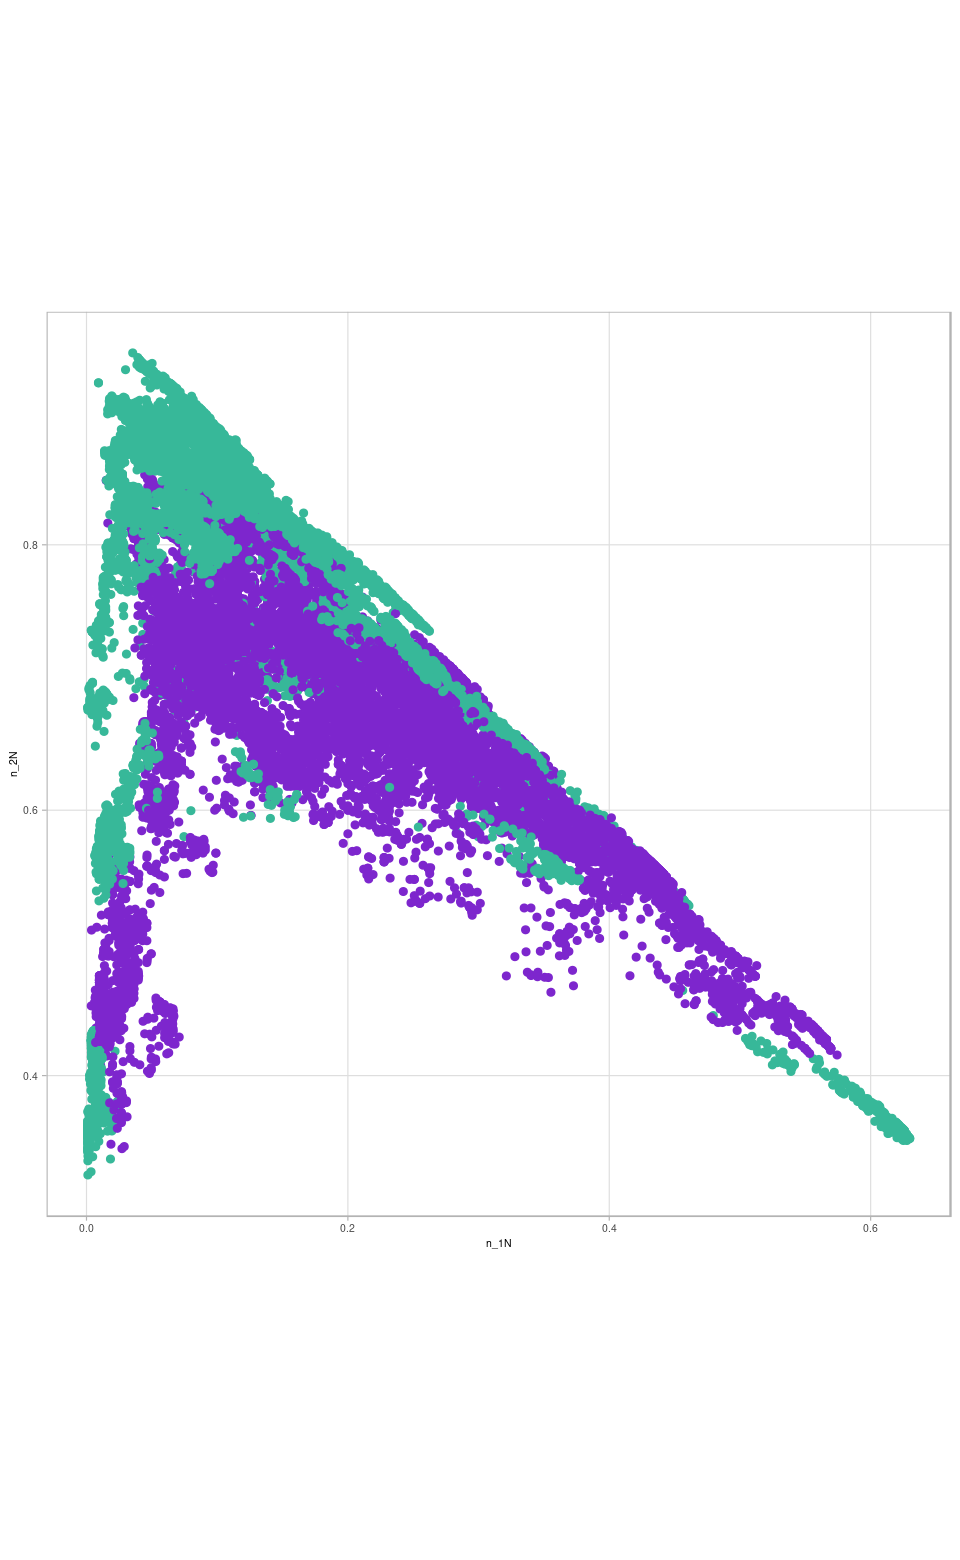

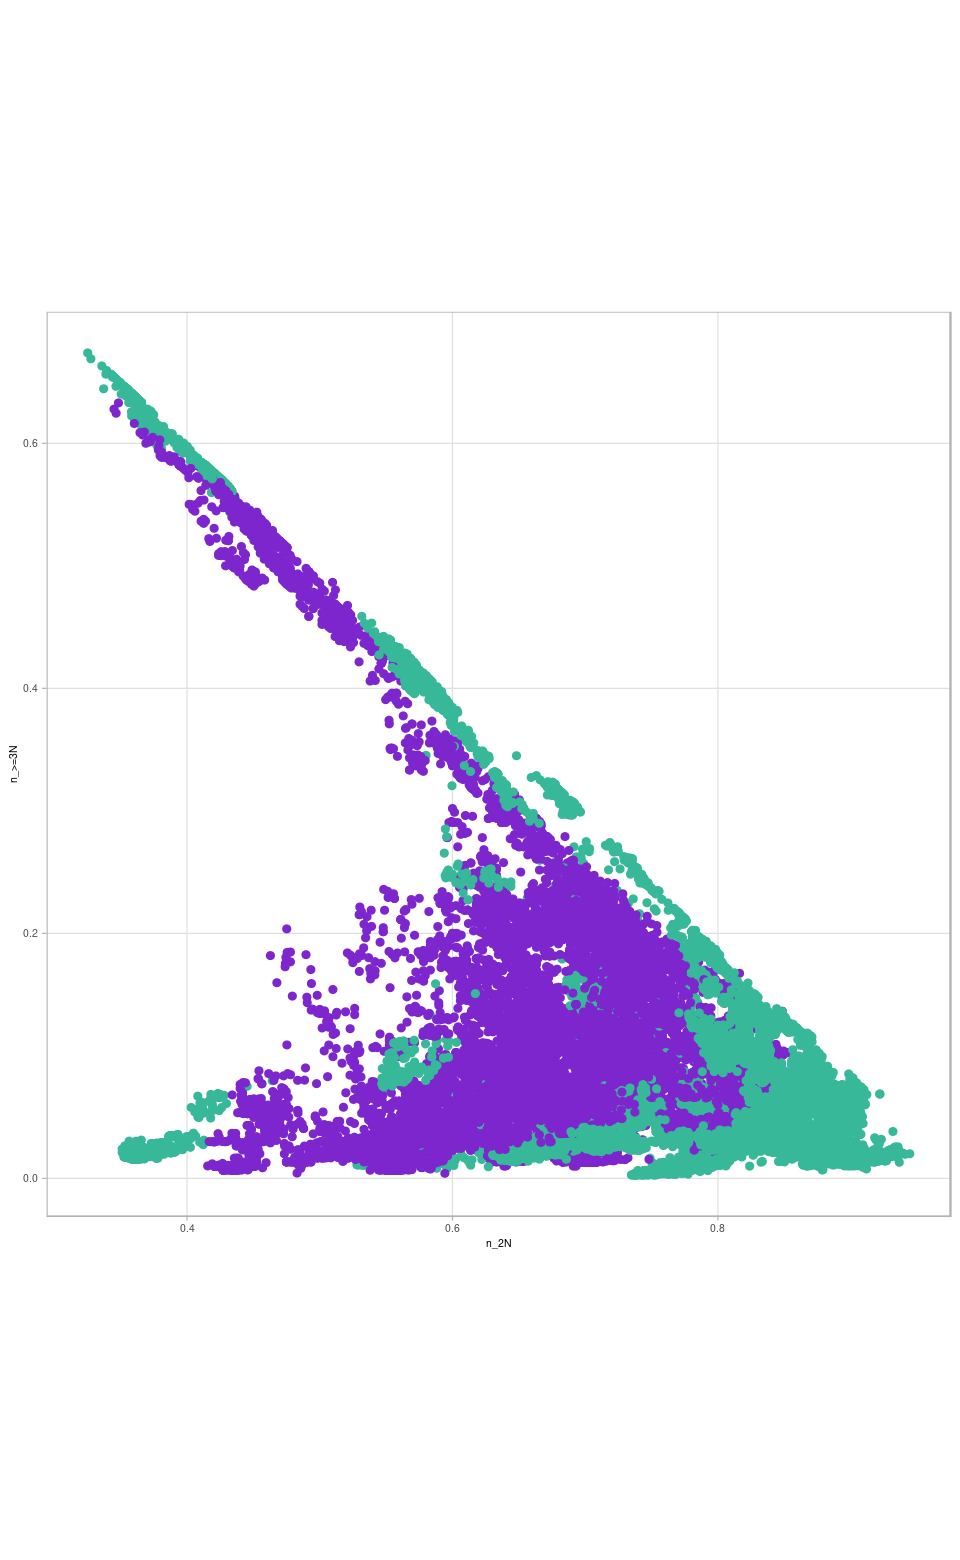

In [55]:
num_cna_meth %>% gather('type', 'num', -(chrom:ER)) %>% group_by(chrom, start, end, ER) %>% mutate(p = num / sum(num))  %>% select(-num) %>% spread(type, p) %>% ggplot(aes(x=`n_1N`, y=`n_2N`, color=ER)) + geom_point() + scale_color_manual(values=annot_colors$ER1, guide = FALSE) + theme(aspect.ratio=1)
num_cna_meth %>% gather('type', 'num', -(chrom:ER)) %>% group_by(chrom, start, end, ER) %>% mutate(p = num / sum(num))  %>% select(-num) %>% spread(type, p) %>% ggplot(aes(x=`n_2N`, y=`n_>=3N`, color=ER)) + geom_point() + scale_color_manual(values=annot_colors$ER1, guide = FALSE) + theme(aspect.ratio=1)

In [56]:
df <- df %>% left_join(num_cna_meth)

Joining, by = c("chrom", "start", "end", "ER")



In [57]:
df_expr <- get_autosome_expr_cna() %>% gather("cna", "expr", -(chrom:ER)) %>% mutate(cna = paste0("expr_", cna)) %>% spread(cna, expr)

In [58]:
df <- df %>% left_join(df_expr)

Joining, by = c("chrom", "start", "end", "ER")



In [59]:
num_cna_expr <- get_autosome_cna() %>% inner_join(get_autosome_loci_expr()) %>% filter(!is.na(expr)) %>% count(chrom, start, end, ER, cna_grp) %>% mutate(cna_grp = paste0("n_expr_", cna_grp)) %>% spread(cna_grp, n)

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end", "samp")



In [60]:
df <- df %>% left_join(num_cna_expr)

Joining, by = c("chrom", "start", "end", "ER")



In [61]:
df <- df %>% left_join(get_gene_expression_mat() %>% select(chrom:end, name) %>% mutate(start = start + 1, end = end + 1))

Joining, by = c("chrom", "start", "end")



In [62]:
fwrite(df, here("data/autosome_cna_meth_expr.tsv"), sep="\t")

In [63]:
thresh <- 0.1

Warning message:
“Removed 100 row(s) containing missing values (geom_path).”
Warning message:
“Removed 100 row(s) containing missing values (geom_path).”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


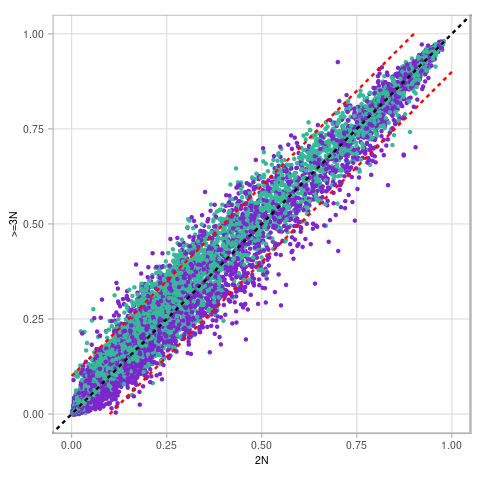

In [64]:
options(repr.plot.width = 4, repr.plot.height = 4)

df %>% ggplot(aes(x = `2N`, y = `>=3N`, color = ER)) +geom_point(size=0.2)  + geom_abline(color = "black", linetype = "dashed") + scale_color_manual(values = annot_colors$ER1, guide = FALSE) + theme(aspect.ratio = 1) + geom_line(data = tibble(`2N` = seq(0,1,0.001), `>=3N`= `2N` - thresh), color="red", linetype="dashed") +  geom_line(data = tibble(`2N` = seq(0,1,0.001), `>=3N`= `2N` + thresh), color="red", linetype = "dashed") + xlim(0,1) + ylim(0,1)


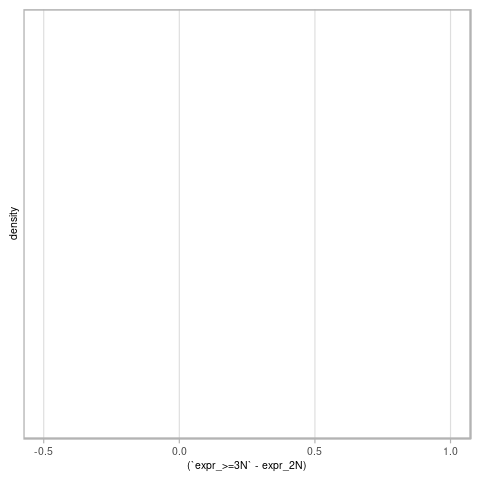

In [65]:
df %>% filter(`>=3N` >= (`2N` + thresh) ) %>% select(chrom, start, end, ER, `>=3N`, `2N`, `n_>=3N`, n_2N, `expr_>=3N`, `expr_2N`, `n_expr_>=3N`, `n_expr_2N`, name) %>% filter(`n_>=3N` >= 5, `n_2N` >= 5, !is.na(name)) %>% arrange(-`n_>=3N`, ER, name) %>% ggplot(aes(x=(`expr_>=3N` - `expr_2N`))) + geom_density() + xlim(-0.5, 1)

In [66]:
df %>% filter(`>=3N` >= (`2N` + thresh) ) %>% select(chrom, start, end, ER, `>=3N`, `2N`, `n_>=3N`, n_2N, `expr_>=3N`, `expr_2N`, `n_expr_>=3N`, `n_expr_2N`, name) %>% filter(`n_>=3N` >= 5, `n_2N` >= 5, !is.na(name)) %>% arrange(-`n_>=3N`, ER, name)

chrom,start,end,ER,>=3N,2N,n_>=3N,n_2N,expr_>=3N,expr_2N,n_expr_>=3N,n_expr_2N,name
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<chr>


In [67]:
df %>% filter(`>=3N` <= (`2N` - thresh) ) %>% select(chrom, start, end, ER, `>=3N`, `2N`, `n_>=3N`, n_2N, `expr_>=3N`, `expr_2N`, `n_expr_>=3N`, `n_expr_2N`, name) %>% filter(`n_>=3N` >= 5, `n_2N` >= 5, !is.na(name))

chrom,start,end,ER,>=3N,2N,n_>=3N,n_2N,expr_>=3N,expr_2N,n_expr_>=3N,n_expr_2N,name
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<chr>


In [69]:
dosage_cands <- df %>% filter(`>=3N` >= (`2N` + thresh) ) %>% select(chrom, start, end, ER, `>=3N`, `2N`, `n_>=3N`, n_2N, `expr_>=3N`, `expr_2N`, `n_expr_>=3N`, `n_expr_2N`, name) %>% filter(`n_>=3N` >= 5, `n_2N` >= 5, !is.na(name)) %>% arrange(-`n_>=3N`, ER, name)

In [70]:
dosage_cands_mean_expr <- dosage_cands %>% select(chrom, start, end, ER) %>% inner_join(get_gene_expression_mat() %>% select(-name3.chr) %>% mutate(start = start + 1, end = end + 1))  %>% gather("samp", "expr", -(chrom:name)) %>% left_join(samp_data %>% select(samp, ER1)) %>% filter(ER == ER1) %>% group_by(chrom, start, end, name, ER) %>% summarise(mean_expr = mean(expr, na.rm=TRUE)) %>% ungroup()
all_mean_expr <- get_gene_expression_mat() %>% select(-name3.chr) %>% mutate(start = start + 1, end = end + 1)  %>% gather("samp", "expr", -(chrom:name)) %>% left_join(samp_data %>% select(samp, ER1)) %>% group_by(chrom, start, end, name, ER1) %>% summarise(mean_expr = mean(expr, na.rm=TRUE)) %>% ungroup()

Joining, by = c("chrom", "start", "end")

Joining, by = "samp"

Joining, by = "samp"



Warning message:
“Removed 34216 rows containing non-finite values (stat_density).”


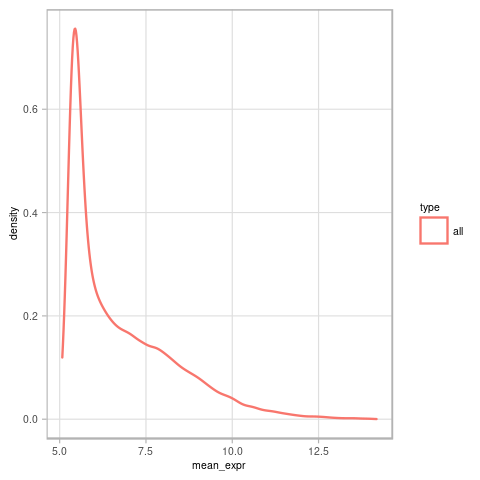

In [71]:
dosage_cands_mean_expr %>% mutate(type = "dosage") %>% bind_rows(all_mean_expr %>% mutate(type = "all")) %>% ggplot(aes(x=mean_expr, color=type)) + geom_density()

Joining, by = "samp"

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end", "samp")

Warning message:
“Removed 569263 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 569263 rows containing non-finite values (stat_signif).”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


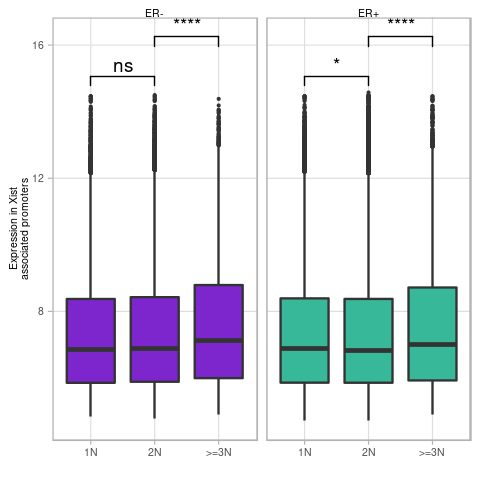

In [72]:
get_xist_cna() %>%
        left_join(get_xist_loci_expr()) %>%
        group_by(cna_grp, samp, ER, chrom, start, end) %>%
        summarise(expr = mean(expr, na.rm = TRUE)) %>%
        ggplot(aes(x = cna_grp, y = expr, fill = ER, group = cna_grp)) +
        geom_boxplot(outlier.size = 0.1) + 
        scale_fill_manual(values = annot_colors$ER1, guide = FALSE) +
        xlab("") +
        ylab("Expression in Xist\nassociated promoters") +
        facet_grid(. ~ ER) +        
        ggpubr::stat_compare_means(label = "p.signif", comparisons = list(c("1N", "2N"), c("2N", ">=3N")))

In [ ]:
gc()